In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader

In [2]:
a1=0.3
a2=1-a1
b1=0.3
b2=0.43

In [12]:
data=np.random.random(10000)*20

a1s=np.random.random(len(data)).astype(np.float32)
a1s=np.ones(len(data))
a2s=1-a1s

b1s=np.random.random(len(data)).astype(np.float32)
b2s=np.random.random(len(data)).astype(np.float32)
b2s=np.zeros(len(data))

times=np.linspace(0,10,100)
decay=np.zeros((data.shape[0],times.shape[0]),dtype=np.float32)
for i,d in enumerate(data):
    a1=a1s[i]
    b1=b1s[i]
    a2=a2s[i]
    b2=b2s[i]
    decay[i]=data[i]*(a1*np.exp(-b1*times)+a2*np.exp(-b2*times))
#dec_data=data[:,None].dot(times[None,:])
#(times[:,None]*data[None,:]).shape
#decay=decay.T
#plt.imshow(decay)

[1.        0.1597135 0.        0.       ]


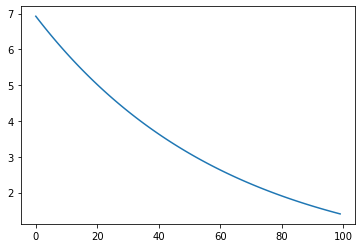

In [13]:
decays = [[np.array(l,dtype=np.float32),np.array([a1s[i],b1s[i],a2s[i],b2s[i]],dtype=np.float32)] for i,l in enumerate(decay.tolist())]
plt.plot(decays[1][0])
print(decays[1][1])

In [14]:
class ExpReg(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.lr=0.001
        self.net=torch.nn.Sequential(
            torch.nn.Linear(100,64),
            torch.nn.ELU(),
            torch.nn.Linear(64,16),
            torch.nn.ELU(),
            torch.nn.Linear(16,4),
            #torch.nn.ELU(),
        )
        self.lossf=torch.nn.MSELoss()
        
        
    def forward(self,x):
        return self.net(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def batch_to_loss(self,batch):
        #display(batch[.shape)
        y_hat=self(batch[0])
        loss = self.lossf(y_hat, batch[1])
        return loss

    def training_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        loss =  self.batch_to_loss(batch)
        self.log('test_loss', loss)
        return loss
        
model=ExpReg()

In [15]:
class DL(pl.LightningDataModule):
    def __init__(self,batch_size=128):
        super().__init__()
        self.batch_size=batch_size
        
    def setup(self, stage=None):
        split=[0,int(len(decays)*0.2),int(len(decays)*0.1)]
        split[0]=len(decays)-sum(split)
        self._train, self._val,self._test = random_split(decays, split)

    def train_dataloader(self):
        return DataLoader(self._train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self._val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self._test, batch_size=self.batch_size)
    
dl=DL()

In [16]:
trainer=pl.Trainer(max_epochs=100,progress_bar_refresh_rate=0)
trainer.fit(model,dl)
trainer.callback_metrics

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | net   | Sequential | 7.6 K 
1 | lossf | MSELoss    | 0     
-------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args

{'train_loss': tensor(1.8690e-05), 'val_loss': tensor(7.5833e-05)}

In [19]:
decays[1][1]

array([1.       , 0.1597135, 0.       , 0.       ], dtype=float32)

In [20]:
model(torch.from_numpy(decays[1][0]))

tensor([1.0020e+00, 1.5661e-01, 3.7209e-03, 3.8251e-05],
       grad_fn=<AddBackward0>)